# Segment Anything (SAM)

This notebook is a tutorial of how to use SAM and FastSAM implementation on images.
make sure you install the library.

### Facebook SAM

Here are the main `pip` installers but for more detailed instructions check out their [GituHub-repo](https://github.com/facebookresearch/segment-anything)

The Facebook SAM requires python>=3.8, as well as pytorch>=1.7 and torchvision>=0.8. Please follow the instructions here to install both PyTorch and TorchVision dependencies. Installing both PyTorch and TorchVision with CUDA support is strongly recommended.

Install Segment Anything:

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

# or clone github repo (comment the previous line and uncomment the following ones for the second option)
# git clone git@github.com:facebookresearch/segment-anything.git
# cd segment-anything; pip install -e .

**Necessary dependencies**

The following optional dependencies are necessary for mask post-processing, saving masks in COCO format, the example notebooks, and exporting the model in ONNX format. jupyter is also required to run the example notebooks.

In [ ]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

#### Quick test of Facebook SAM on YOLO bbox

1. To test the installation, let's use the obtained weights from YOLO training.


image 1/1 e:\RHS\RHS - finalthesis\SurgiKneeVision-main\knee_segmentation_robo\valid\images\00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg: 640x640 1 Knee, 1.6ms
Speed: 15.6ms preprocess, 1.6ms inference, 67.8ms postprocess per image at shape (1, 3, 640, 640)


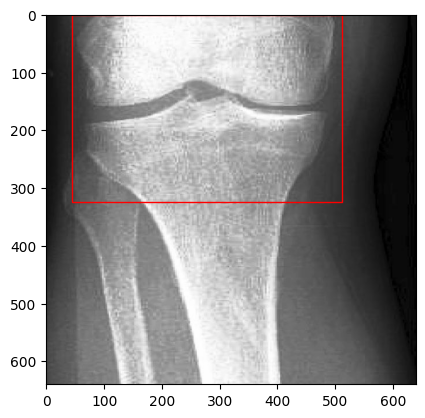

In [3]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# load the YOLOv8 model
model = YOLO(f'models/YOLOv8n_custom.pt')

# Load the image
image_path = 'knee_segmentation_robo/valid/images/00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg'
image = Image.open(image_path)

# run the model on the image
results = model.predict(source=image_path, conf=0.50)
predicted_boxes = results[0].boxes.xyxy

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Get the predicted boxes
predicted_boxes = results[0].boxes.xyxy.cpu().numpy()  # Convert to NumPy on CPU

# Draw bounding boxes on the image
for box in predicted_boxes:
    x, y, w, h = box[:4]
    rect = patches.Rectangle((x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis('on')
plt.show()


2. You need to a checkpoint of corresponding model. In this tutorial [ViT-H_SAM_model](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth) has been selected. you need to store it the original project folder

In [6]:
import torch
from segment_anything import SamPredictor, sam_model_registry

# load the SAM model
sam = sam_model_registry["vit_b"](checkpoint="models/sam-vit-base_custom_box.pth").to(device=torch.device('cuda:0'))
mask_predictor = SamPredictor(sam)

In [7]:
import numpy as np

# Convert the PIL Image to a NumPy array
image_array = np.array(image)

# transform the YOLOv8 predicted boxes to match input format expected by SAM model
torch_boxes = torch.from_numpy(predicted_boxes)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(torch_boxes, image_array.shape[:2])
#transformed_boxes = yolo_bbox2segment(im_dir, save_dir=None, sam_model='sam_b.pt', device=None)

# Move the transformed_boxes to the same device as the model
transformed_boxes = transformed_boxes.to(device='cuda:0')

# run SAM model on all the boxes
mask_predictor.set_image(image_array)
masks, scores, logits = mask_predictor.predict_torch(
   boxes=transformed_boxes,
   multimask_output=False,
   point_coords=None,
   point_labels=None
)

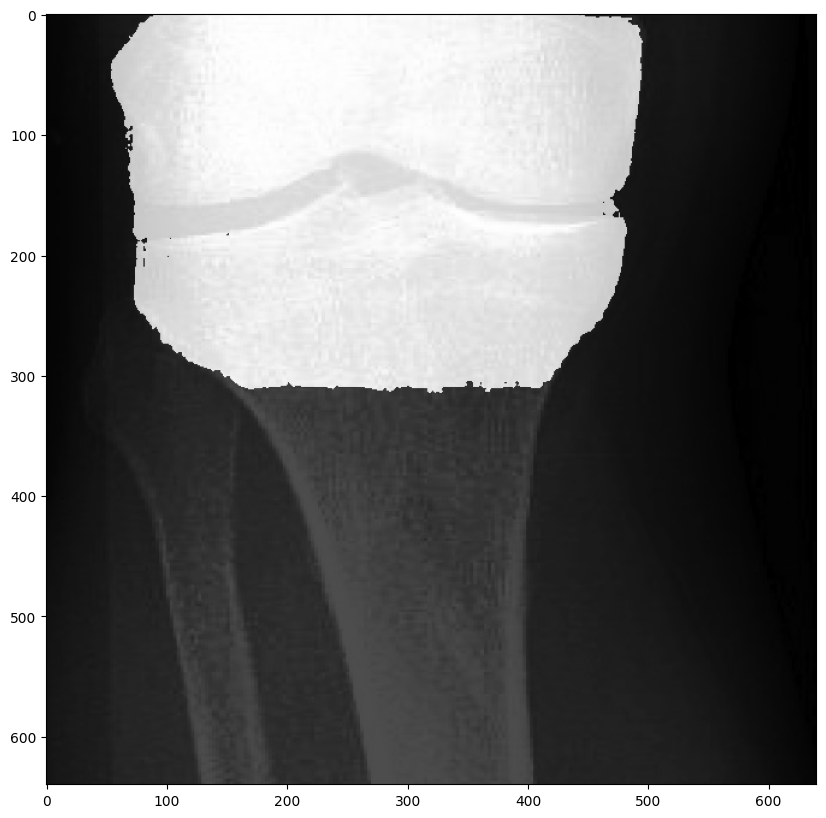

In [8]:
# combine all masks into one for easy visualization
final_mask = None
for mask in masks:
    mask_array = mask[0].cpu().numpy()  # Move to CPU and convert to NumPy array
    if final_mask is None:
        final_mask = np.bitwise_or(mask_array, 0)
    else:
        final_mask = np.bitwise_or(final_mask, mask_array)

# visualize the predicted masks
plt.figure(figsize=(10, 10))
plt.imshow(image_array)

# Apply colormap to visualize the mask
plt.imshow(final_mask, cmap='gray', alpha=0.7)

plt.show()


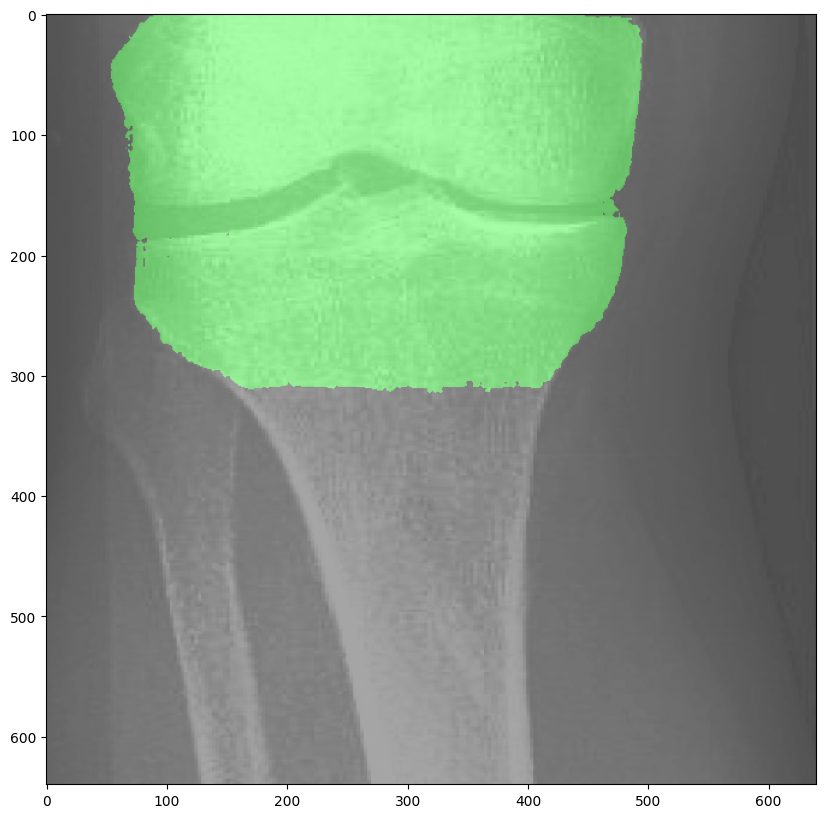

In [9]:
import cv2

alpha = 0.5
overlay_image = image_array.copy()
colored_mask = np.zeros_like(overlay_image)
colored_mask[final_mask > 0] = [0, 255, 0]  # Green color for mask
img_with_annotations = cv2.addWeighted(overlay_image, 1 - alpha, colored_mask, alpha, 0)

# visualize the predicted masks
plt.figure(figsize=(10, 10))

plt.imshow(img_with_annotations, cmap= "grey", alpha=0.7)

plt.show()


You can also try with other Facebook SAM models `vit_h`, `vit_l` and `vit_b`

- `vit_h` stands for ViT Huge Model Card for Segment Anything Model (SAM)
- `vit_l` stands for ViT Large Model Card for Segment Anything Model (SAM)
- `vit_b` stands for ViT Base Model Card for Segment Anything Model (SAM)

checkout the details at [Facebook_huggingface](https://huggingface.co/facebook/) repositories.

`vit_h` seems to be the best at performing SAM.

The following is a test using `vit_l` and without loading a checkpoint.

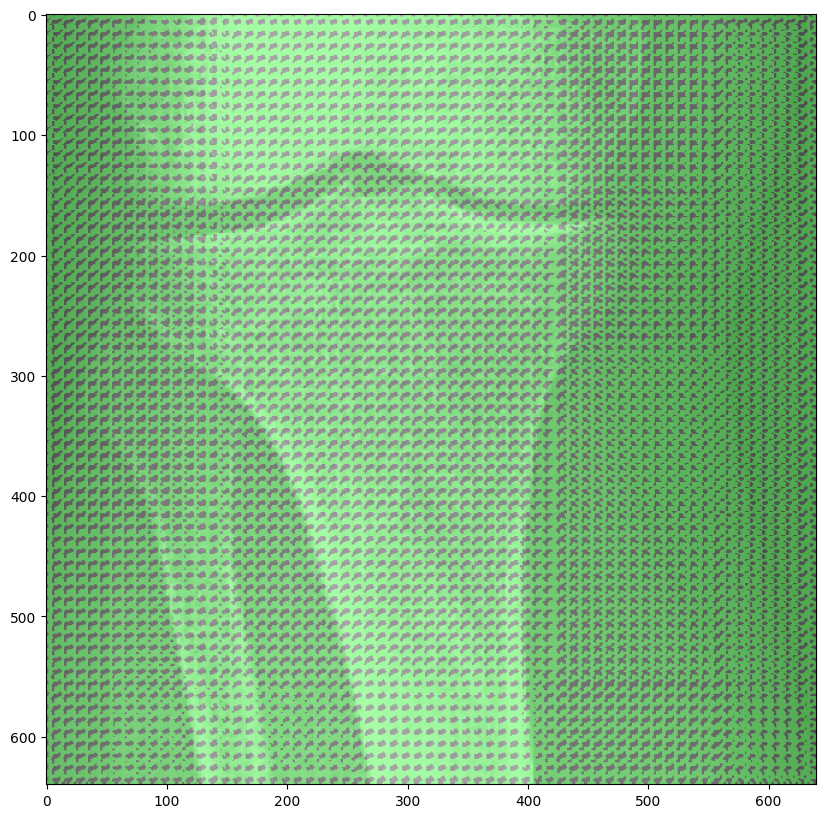

In [10]:
from segment_anything import SamPredictor, sam_model_registry
import torch
import numpy as np
import cv2

# load the SAM model
sam = sam_model_registry["vit_l"]().to(device=torch.device('cuda:0')) 
mask_predictor = SamPredictor(sam)


# Convert the PIL Image to a NumPy array
image_array = np.array(image)

# transform the YOLOv8 predicted boxes to match input format expected by SAM model
torch_boxes = torch.from_numpy(predicted_boxes)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(torch_boxes, image_array.shape[:2])

# Move the transformed_boxes to the same device as the model
transformed_boxes = transformed_boxes.to(device='cuda:0')

# run SAM model on all the boxes
mask_predictor.set_image(image_array)
masks, scores, logits = mask_predictor.predict_torch(
   boxes=transformed_boxes,
   multimask_output=False,
   point_coords=None,
   point_labels=None
)

# combine all masks into one for easy visualization
final_mask = None
for mask in masks:
    mask_array = mask[0].to(device='cuda:0').cpu().numpy()  # Move to CPU and convert to NumPy array
    if final_mask is None:
        final_mask = np.bitwise_or(mask_array, 0)
    else:
        final_mask = np.bitwise_or(final_mask, mask_array)

alpha = 0.5
overlay_image = image_array.copy()
colored_mask = np.zeros_like(overlay_image)
colored_mask[final_mask > 0] = [0, 255, 0]  # Green color for mask
img_with_annotations = cv2.addWeighted(overlay_image, 1 - alpha, colored_mask, alpha, 0)

# visualize the predicted masks
plt.figure(figsize=(10, 10))

plt.imshow(img_with_annotations, cmap= "grey", alpha=0.7)

plt.show()


## FastSAM Installation

Let's now check the result of FastSAM.
First, you need to download the FastSAM in home folder. Follow the instructions as mentionned in [FastSAM_Github](https://github.com/CASIA-IVA-Lab/FastSAM) repository.

Or run the following cell

In [11]:
import os

# Define the folder name
folder_name = "FastSAM"

# Check if the folder already exists
if os.path.exists(folder_name):
    print(f"The folder '{folder_name}' already exists. Skipping git clone.")
else:
    # Clone the repo
    !git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
    print(f"Repository cloned successfully into the '{folder_name}' folder.")


The folder 'FastSAM' already exists. Skipping git clone.


Let's run FastSAM on the full image and segment everything:

cuda


image 1/1 e:\RHS\RHS - finalthesis\SurgiKneeVision-main\knee_segmentation_robo\valid\images\00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg: 640x640 2 objects, 29.6ms
Speed: 0.0ms preprocess, 29.6ms inference, 17.6ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

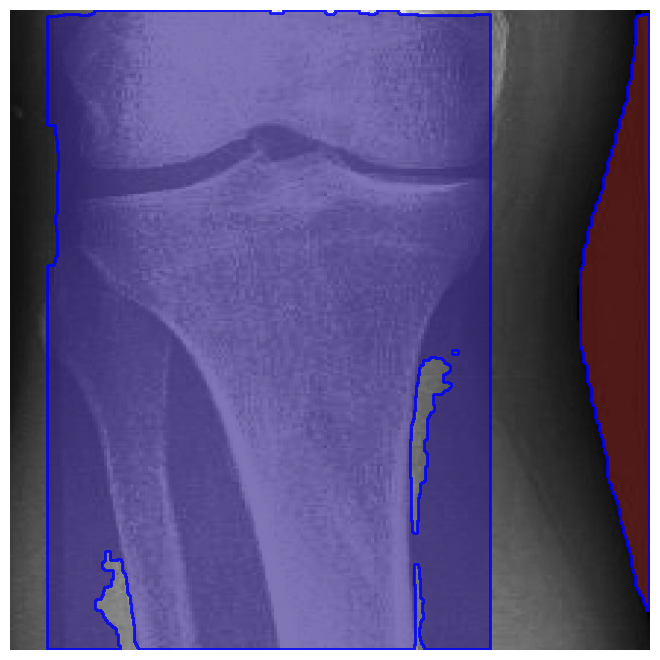

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
from FastSAM.fastsam import FastSAM, FastSAMPrompt


model = FastSAM('FastSAM-s.pt')

DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(DEVICE)

IMAGE_PATH = 'knee_segmentation_robo/valid/images/00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg'

everything_results = model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=640, conf=0.4, iou=0.9,)
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)

# everything prompt for the full image
ann = prompt_process.everything_prompt()

# Get the image with annotations
img_with_annotations = prompt_process.plot_to_result(annotations=ann)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img_with_annotations, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()





The results looks less accurate than Facebook SAM model but quite decent and runs very Fast

Let's now apply YOLO to detect the green cup and segment only this object:


image 1/1 e:\RHS\RHS - finalthesis\SurgiKneeVision-main\knee_segmentation_robo\valid\images\00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg: 640x640 1 Knee, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


cuda:0
tensor([[ 44.5523,   0.0000, 512.5350, 324.2599,   0.9490,   0.0000]], device='cuda:0')
bounding box: [np.int64(44), np.int64(0), np.int64(512), np.int64(324)]



image 1/1 e:\RHS\RHS - finalthesis\SurgiKneeVision-main\knee_segmentation_robo\valid\images\00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg: 640x640 2 objects, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

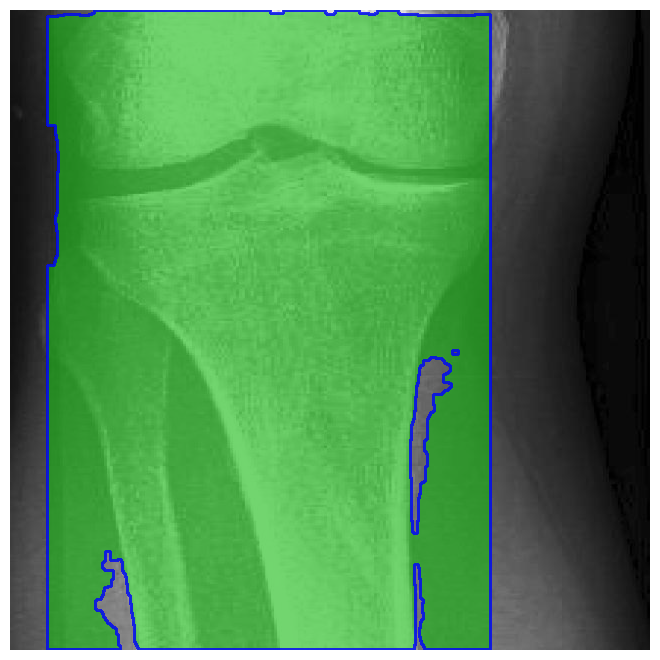

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from ultralytics import YOLO
from PIL import Image
import os
#from ultralytics import FastSAM

# Load YOLOv8 model
yolo_model = YOLO('models/YOLOv8n_custom.pt')

# Load FastSAM model
fastsam_model = FastSAM('FastSAM-s.pt')

DEVICE = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(DEVICE)

# Load the image
IMAGE_PATH = 'knee_segmentation_robo/valid/images/00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg'
image = Image.open(IMAGE_PATH)

# Run YOLOv8 on the image
results = yolo_model.predict(source=IMAGE_PATH, conf=0.50)

for r in results:
    print(r.boxes.data)

# Get the predicted boxes
predicted_boxes = results[0].boxes.xyxy.cpu().numpy()  # Convert to NumPy on CPU

# Use the first predicted box for FastSAM
first_box = predicted_boxes[0]

# Crop the detected object from the image
x, y, w, h = first_box[:4].astype(int)
cropped_object = np.array(image.crop((x, y, w, h)))

# Create a figure and axis
#fig, ax = plt.subplots(1)

# Display the image
#ax.imshow(cropped_object)

#x2, y2 = x + w, y + h

# Create an array in the format [x1, y1, x2, y2]
bounding_box = [x, y, w, h]
print("bounding box:", bounding_box)

# Run FastSAM on the cropped object
fastsam_results = fastsam_model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=640, conf=0.3, iou=0.7,)

prompt_process = FastSAMPrompt(IMAGE_PATH, fastsam_results, device=DEVICE)

# Use bounding_box as a single bounding box
ann = prompt_process.box_prompt(bbox=bounding_box)

# Get the image with annotations
img_with_annotations = prompt_process.plot_to_result(annotations=ann)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img_with_annotations, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

In [15]:
import open3d as o3d
o3d.io.AzureKinectSensor.list_devices()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Device index 0
[Open3D INFO] Serial number: 001191214312
[Open3D INFO] Firmware build: Rel
[Open3D INFO] > Color: 1.6.110
[Open3D INFO] > Depth: 1.6.80[6109.7]


True